# Figure 1.h - Retraining of a supervised 3D model with unsupervised labels
Goals : 

- Show that a 3D model retrained using the output of an unsupervised model can perform similarly than a model trained on ground truth labels.

In [1]:
import numpy as np
from tifffile import imread
import sys
import numpy as np

import pyclesperanto_prototype as cle
from stardist.matching import matching_dataset
sys.path.append("../..")

from utils import *
from plots import *
print("Used GPU: ", cle.get_device())
show_params()
#################
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = True

Used GPU:  <Intel(R) UHD Graphics 620 on Platform: Intel(R) OpenCL (1 refs)>
Plot parameters (set in plots.py) : 
- COLORMAP : ████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 20
- Title font size : 25.0
- Label font size : 20.0


In [2]:
%load_ext autoreload
%autoreload 2

## Data

In [3]:
data_path = DATA_PATH / "RESULTS/SUPERVISED_PERF_FIG/INFERENCE"
fold1_path = data_path / "fold1"
fold2_path = data_path / "fold2"
fold3_path = data_path / "fold3"

def get_fold_data(fold_path):
    return [imread(f) for f in fold_path.glob("*.tif") if "label" not in f.name], [imread(f) for f in fold_path.glob("*.tif") if "label" in f.name]

images = []
GT_labels = []
for fold in [fold1_path, fold2_path, fold3_path]:
    im, GT_lab = get_fold_data(fold)
    images.append(im[0])
    GT_labels.append(GT_lab[0])

In [4]:
fold_paths = [fold1_path, fold2_path, fold3_path]

def get_predictions(path):
    return [imread(f) for f in path.glob("*.tif")]
#################
swin_paths = [f / "Swin" for f in fold_paths]
segresnet_paths = [f / "SegResNet" for f in fold_paths]

swin_predictions = [get_predictions(p)[0] for p in swin_paths]
segresnet_predictions = [get_predictions(p)[0] for p in segresnet_paths]

In [5]:
swin_wnet_path = DATA_PATH / "RESULTS/WNET_RETRAIN/inference"
swin_wnet_predictions = [imread(str(f)) for f in swin_wnet_path.glob("*.tif")]
swin_wnet_predictions.reverse()

In [6]:
wnet_path = DATA_PATH / "RESULTS/WNET_RETRAIN/inference/WNet"
wnet_predictions = [imread(str(f)) for f in wnet_path.glob("*.tif")]
wnet_predictions.reverse()

## Computations

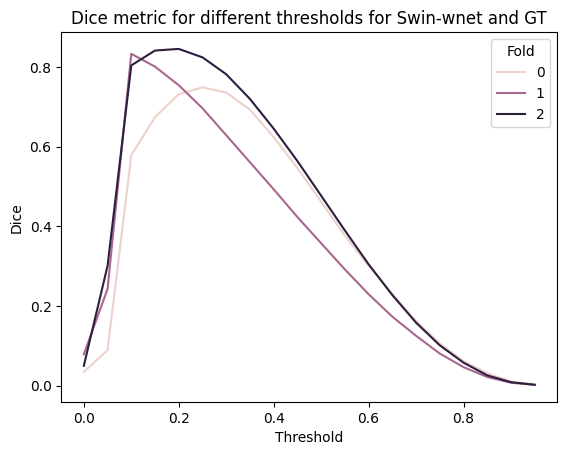

In [7]:
# plot dice metric for several thresholds for swin-wnet and GT using a dataframe that records which threshold and fold the dice was calculated for
thresh = np.arange(0, 1, 0.05)
rows = []
for t in thresh:
    for i, (gt, pred) in enumerate(zip(GT_labels, swin_wnet_predictions)):
        dices_row = {"Threshold": t, "Fold": i, "Dice": dice_coeff(
            np.where(gt > 0, 1, 0),
            np.where(pred > t, 1, 0)
            )}
        rows.append(dices_row)
        
dices_df = pd.DataFrame(rows)

sns.lineplot(data=dices_df, x="Threshold", y="Dice", hue="Fold")
plt.title("Dice metric for different thresholds for Swin-wnet and GT")
plt.show()

In [8]:
dices_df.groupby("Threshold").mean().sort_values("Dice", ascending=False).head(5)

,Fold,Dice
Threshold,,
0.20,1.0,0.777428
0.15,1.0,0.772413
0.25,1.0,0.756872
0.10,1.0,0.738819
0.30,1.0,0.715765


In [9]:
swin_thresholded = [np.where(swin > 0.4, swin, 0) for swin in swin_predictions]
segresnet_thresholded = [np.where(segresnet > 0.3, segresnet, 0) for segresnet in segresnet_predictions]
swin_wnet_thresholded = [np.where(wnet > 0.2, wnet, 0) for wnet in swin_wnet_predictions]

In [10]:
swin_instance = []
segresnet_instance = []
swin_wnet_instance = []
###
wnet_instance = wnet_predictions # these are already instance labels

for i in range(len(fold_paths)):
    swin_instance.append(np.array(
        cle.voronoi_otsu_labeling(swin_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                         )
    segresnet_instance.append(np.array(
        cle.voronoi_otsu_labeling(segresnet_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                              )
    swin_wnet_instance.append(np.array(
        cle.voronoi_otsu_labeling(swin_wnet_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                             )

In [11]:
# from tifffile import imwrite
# for i in range(len(fold_paths)):
#     save_folder = data_path / "processed" / f"fold{i+1}"
#     save_folder.mkdir(exist_ok=True, parents=False)
#     imwrite(save_folder / "swin_instance.tif", swin_instance[i])
#     imwrite(save_folder / "segresnet_instance.tif", segresnet_instance[i])

## Plots

In [12]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predictions = [
#    segresnet_instance,
   swin_instance,
   swin_wnet_instance,
   wnet_instance,
#    cellpose_predictions,
#    stardist_predictions,
   ]
names = [
    "SwinUNetR",
    # "SegResNet",
    "Swin (WNet3D labels)",
    "WNet3D (pre-trained)",
    #  "Cellpose",
    #  "Stardist",
    ]
swin_darker,_ = get_shades(COLORMAP[3])
CUSTOM_CMAP = [COLORMAP[3], swin_darker, COLORMAP[5]]

model_stats = []
model_ref_name = []
fold_ref = []

for j, fold in enumerate(fold_paths):
    print("Fold ", j+1)
    for i, p in enumerate(predictions):
        print(f"Validating on {names[i]}")
        stats = [matching_dataset(
            GT_labels[j], p[j], thresh=t, show_progress=False
            ) for t in taus]
        model_stats.append(stats)
        for t in taus:
            model_ref_name.append(names[i])
            fold_ref.append(j+1)
        # uncomment for ALL plots : 
        # plot_performance(taus, stats, name=names[i])
        print("*"*20)

Fold  1
Validating on SwinUNetR
********************
Validating on Swin (WNet3D labels)
********************
Validating on WNet3D (pre-trained)
********************
Fold  2
Validating on SwinUNetR
********************
Validating on Swin (WNet3D labels)
********************
Validating on WNet3D (pre-trained)
********************
Fold  3
Validating on SwinUNetR
********************
Validating on Swin (WNet3D labels)
********************
Validating on WNet3D (pre-trained)
********************


In [13]:
dfs = [dataset_matching_stats_to_df(s) for s in model_stats]
df = pd.concat(dfs)
df["Model"] = model_ref_name
df["Fold"] = fold_ref
df["thresh"] = df.index
df.set_index(["Model", "Fold", "thresh"], inplace=True)
df

criterion    fp    tp    fn  precision  \
Model                Fold thresh                                          
SwinUNetR            1    0.1          iou   724  3017   368   0.806469   
                          0.2          iou   740  3001   384   0.802192   
                          0.3          iou   781  2960   425   0.791232   
                          0.4          iou   810  2931   454   0.783480   
                          0.5          iou   892  2849   536   0.761561   
...                                    ...   ...   ...   ...        ...   
WNet3D (pre-trained) 3    0.5          iou   974  4656  2253   0.826998   
                          0.6          iou  1640  3990  2919   0.708703   
                          0.7          iou  2400  3230  3679   0.573712   
                          0.8          iou  3397  2233  4676   0.396625   
                          0.9          iou  4704   926  5983   0.164476   

                                    recall  accuracy        f1  n_true  \
Model                Fold thresh                                         
SwinUNetR            1    0.1     0.891285  0.734242  0.846758    3385   
                          0.2     0.886558  0.727515  0.842268    3385   
                          0.3     0.874446  0.710514  0.830761    3385   
                          0.4     0.865879  0.698689  0.822621    3385   
                          0.5     0.841654  0.666121  0.799607    3385   
...                                    ...       ...       ...     ...   
WNet3D (pre-trained) 3    0.5     0.673904  0.590638  0.742643    6909   
                          0.6     0.577508  0.466721  0.636414    6909   
                          0.7     0.467506  0.346976  0.515193    6909   
                          0.8     0.323202  0.216670  0.356169    6909   
                          0.9     0.134028  0.079738  0.147699    6909   

                                  n_pred  mean_true_score  mean_matched_score  \
Model                Fold thresh                                                
SwinUNetR            1    0.1       3741         0.705704            0.791782   
                          0.2       3741         0.705090            0.795311   
                          0.3       3741         0.702058            0.802860   
                          0.4       3741         0.699128            0.807420   
                          0.5       3741         0.688671            0.818235   
...                                  ...              ...                 ...   
WNet3D (pre-trained) 3    0.5       5630         0.518749            0.769767   
                          0.6       5630         0.467688            0.809838   
                          0.7       5630         0.396466            0.848045   
                          0.8       5630         0.288912            0.893907   
                          0.9       5630         0.129802            0.968467   

                                  panoptic_quality  by_image  
Model                Fold thresh                              
SwinUNetR            1    0.1             0.670448     False  
                          0.2             0.669865     False  
                          0.3             0.666984     False  
                          0.4             0.664201     False  
                          0.5             0.654266     False  
...                                            ...       ...  
WNet3D (pre-trained) 3    0.5             0.571662     False  
                          0.6             0.515393     False  
                          0.7             0.436907     False  
                          0.8             0.318382     False  
                          0.9             0.143042     False  

[81 rows x 14 columns]

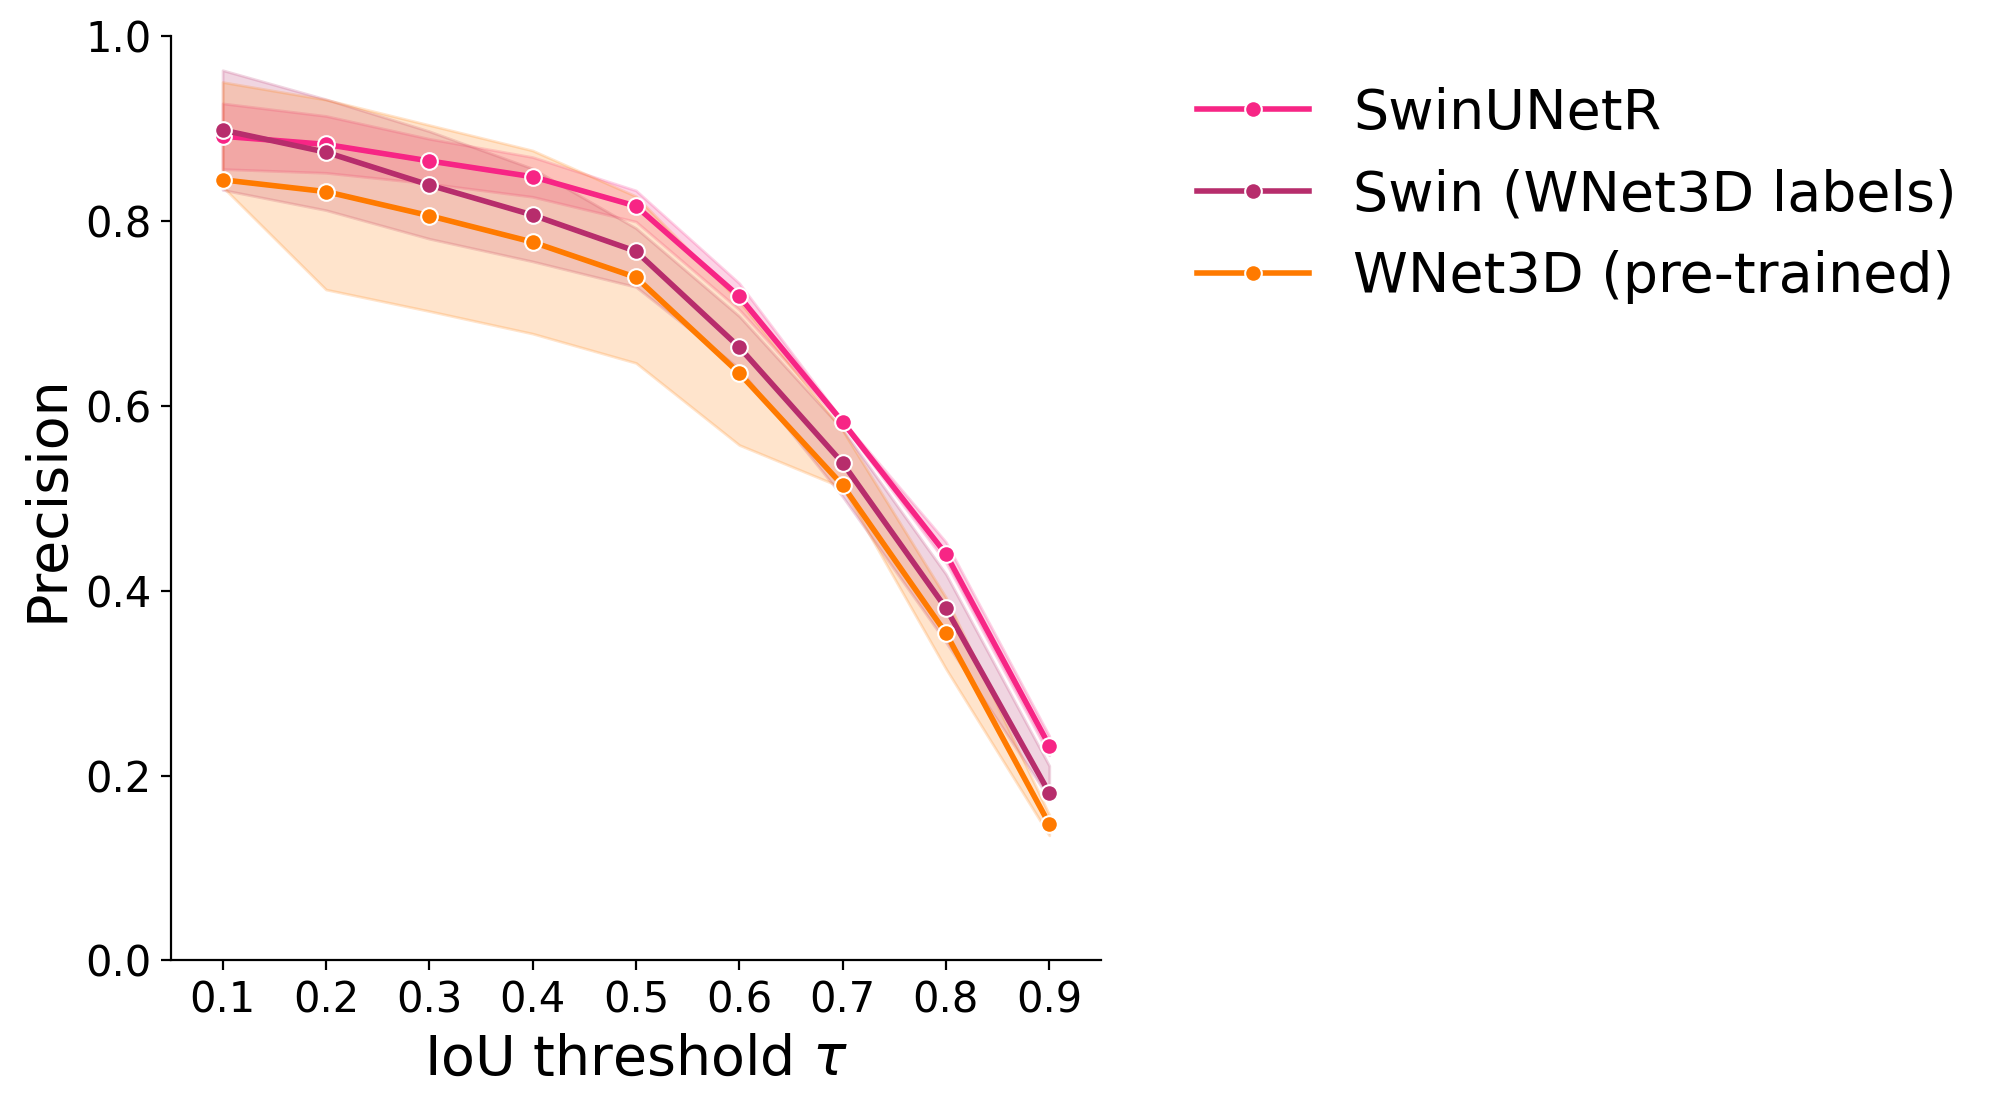

In [14]:
plot_stat_comparison_fold(df, stat="precision", colormap=CUSTOM_CMAP)
if SAVE_PLOTS_AS_PNG:
    plt.savefig( "precision_comparison.png", bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig( "precision_comparison.svg", bbox_inches="tight")

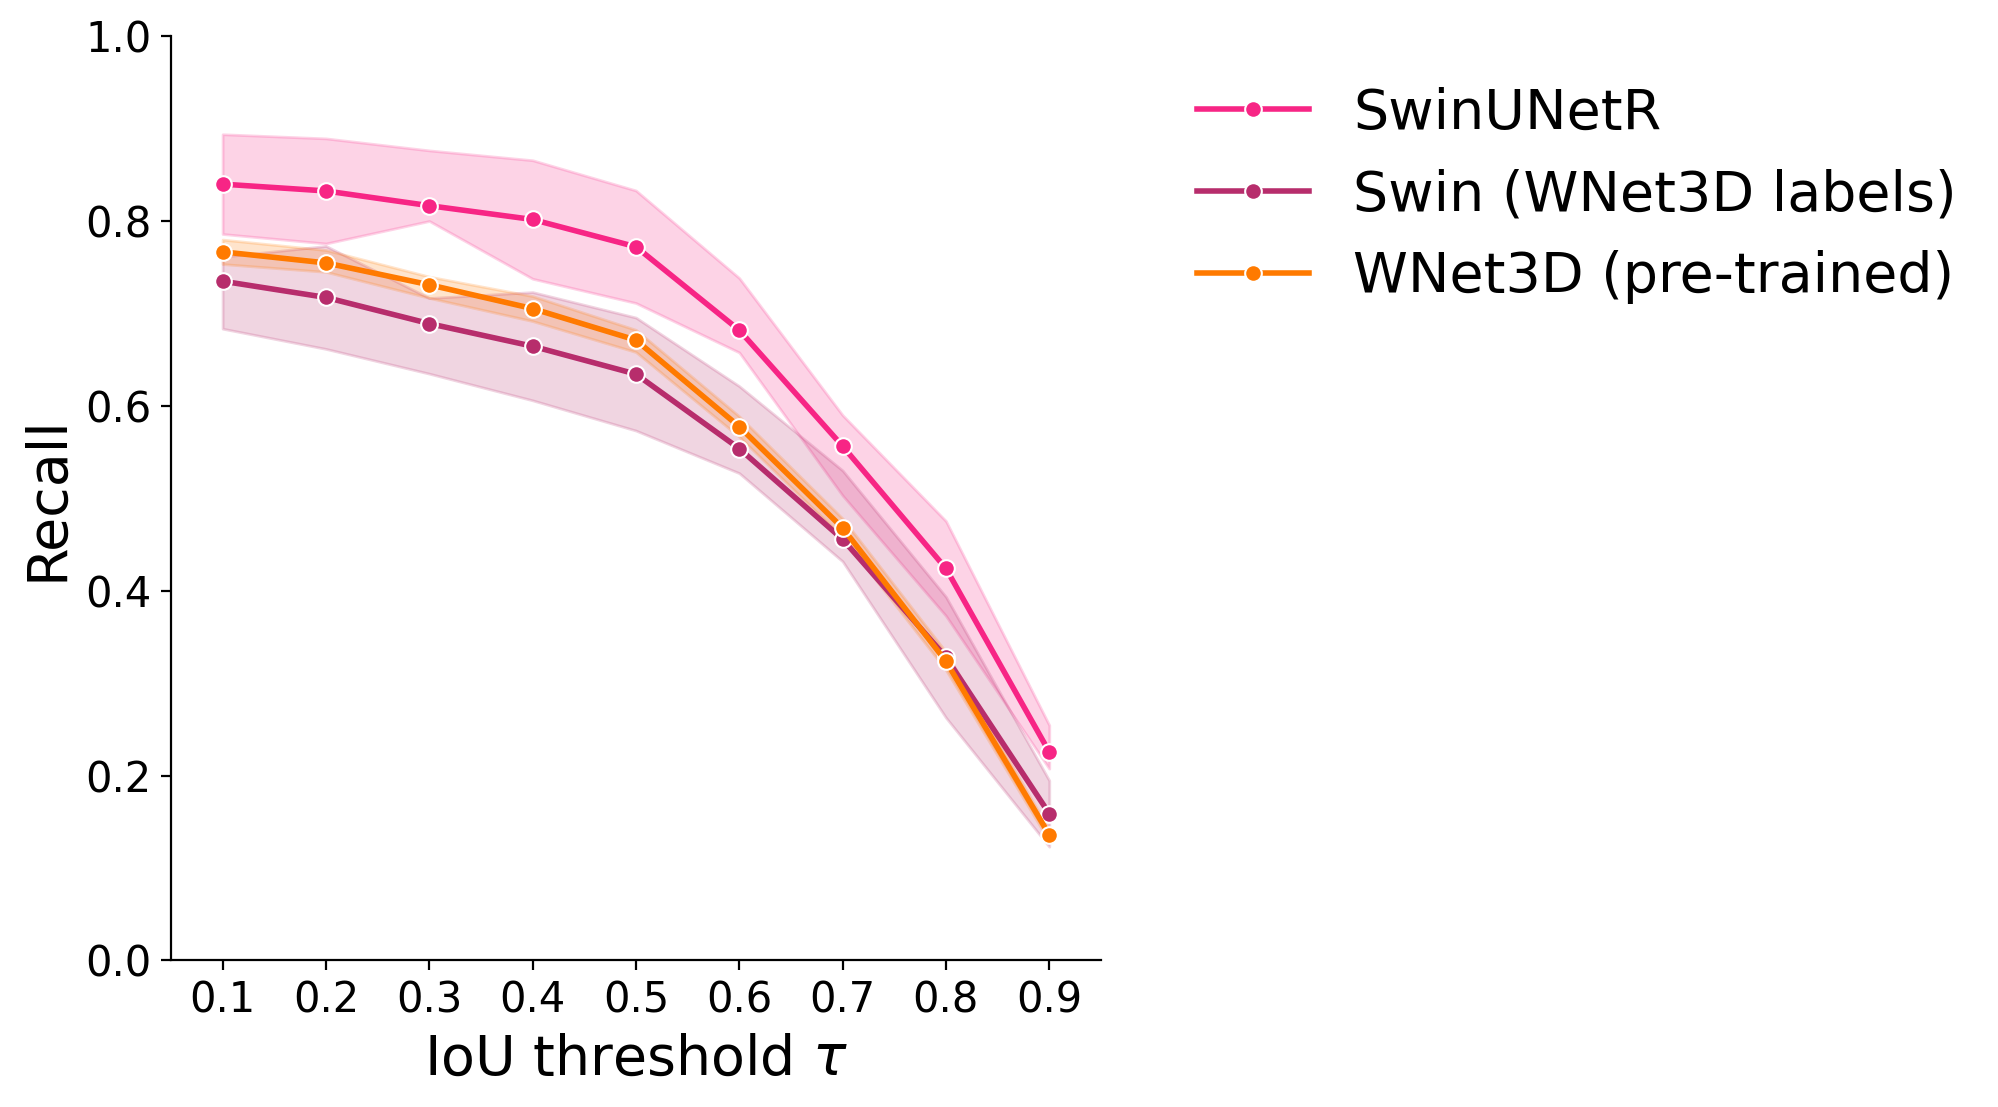

In [15]:
plot_stat_comparison_fold(df, stat="recall", colormap=CUSTOM_CMAP)
if SAVE_PLOTS_AS_PNG:
    plt.savefig( "recall_comparison.png")
if SAVE_PLOTS_AS_SVG:
    plt.savefig( "recall_comparison.svg", bbox_inches="tight")

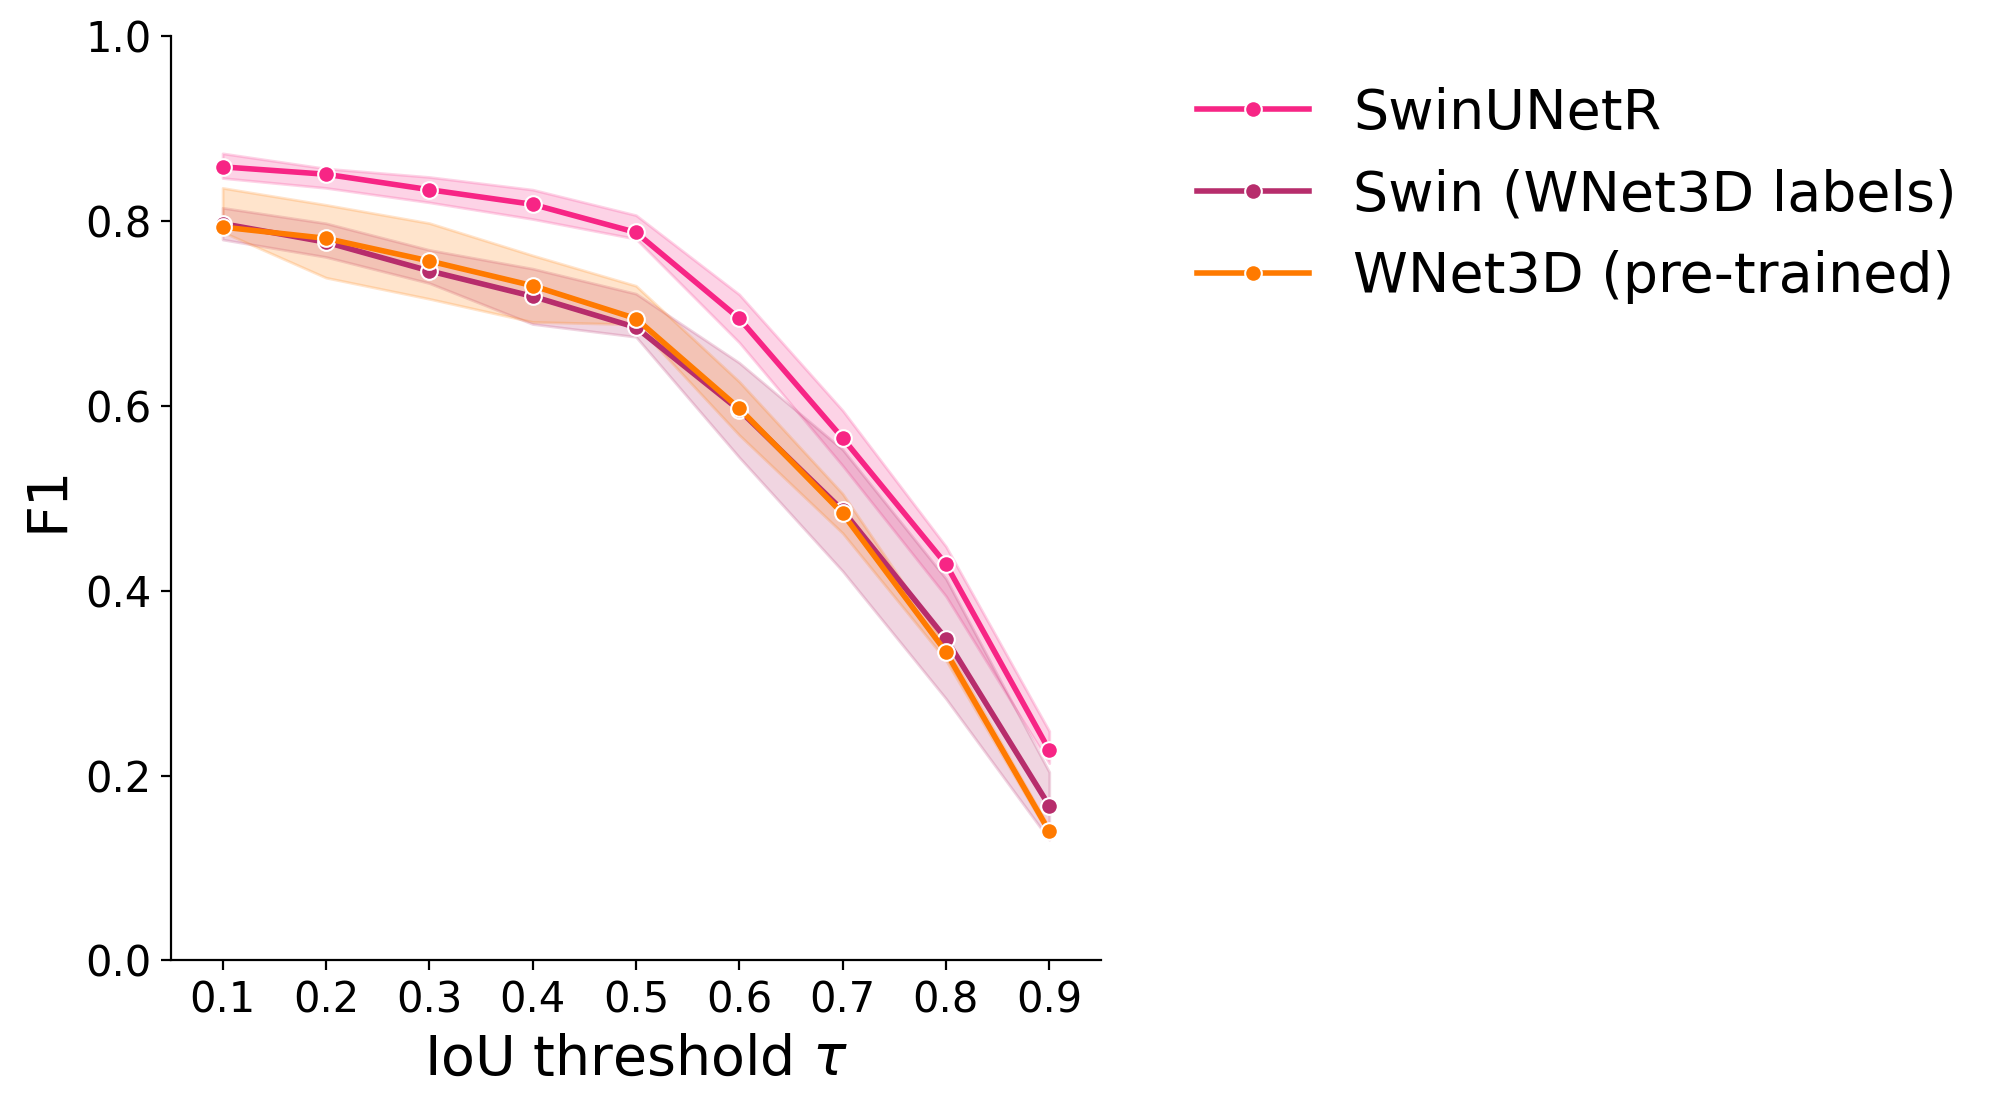

In [16]:
plot_stat_comparison_fold(df, stat="f1", colormap=CUSTOM_CMAP)
if SAVE_PLOTS_AS_PNG:
    plt.savefig( "f1_comparison.png")
if SAVE_PLOTS_AS_SVG:
    plt.savefig( "f1_comparison.svg", bbox_inches="tight")

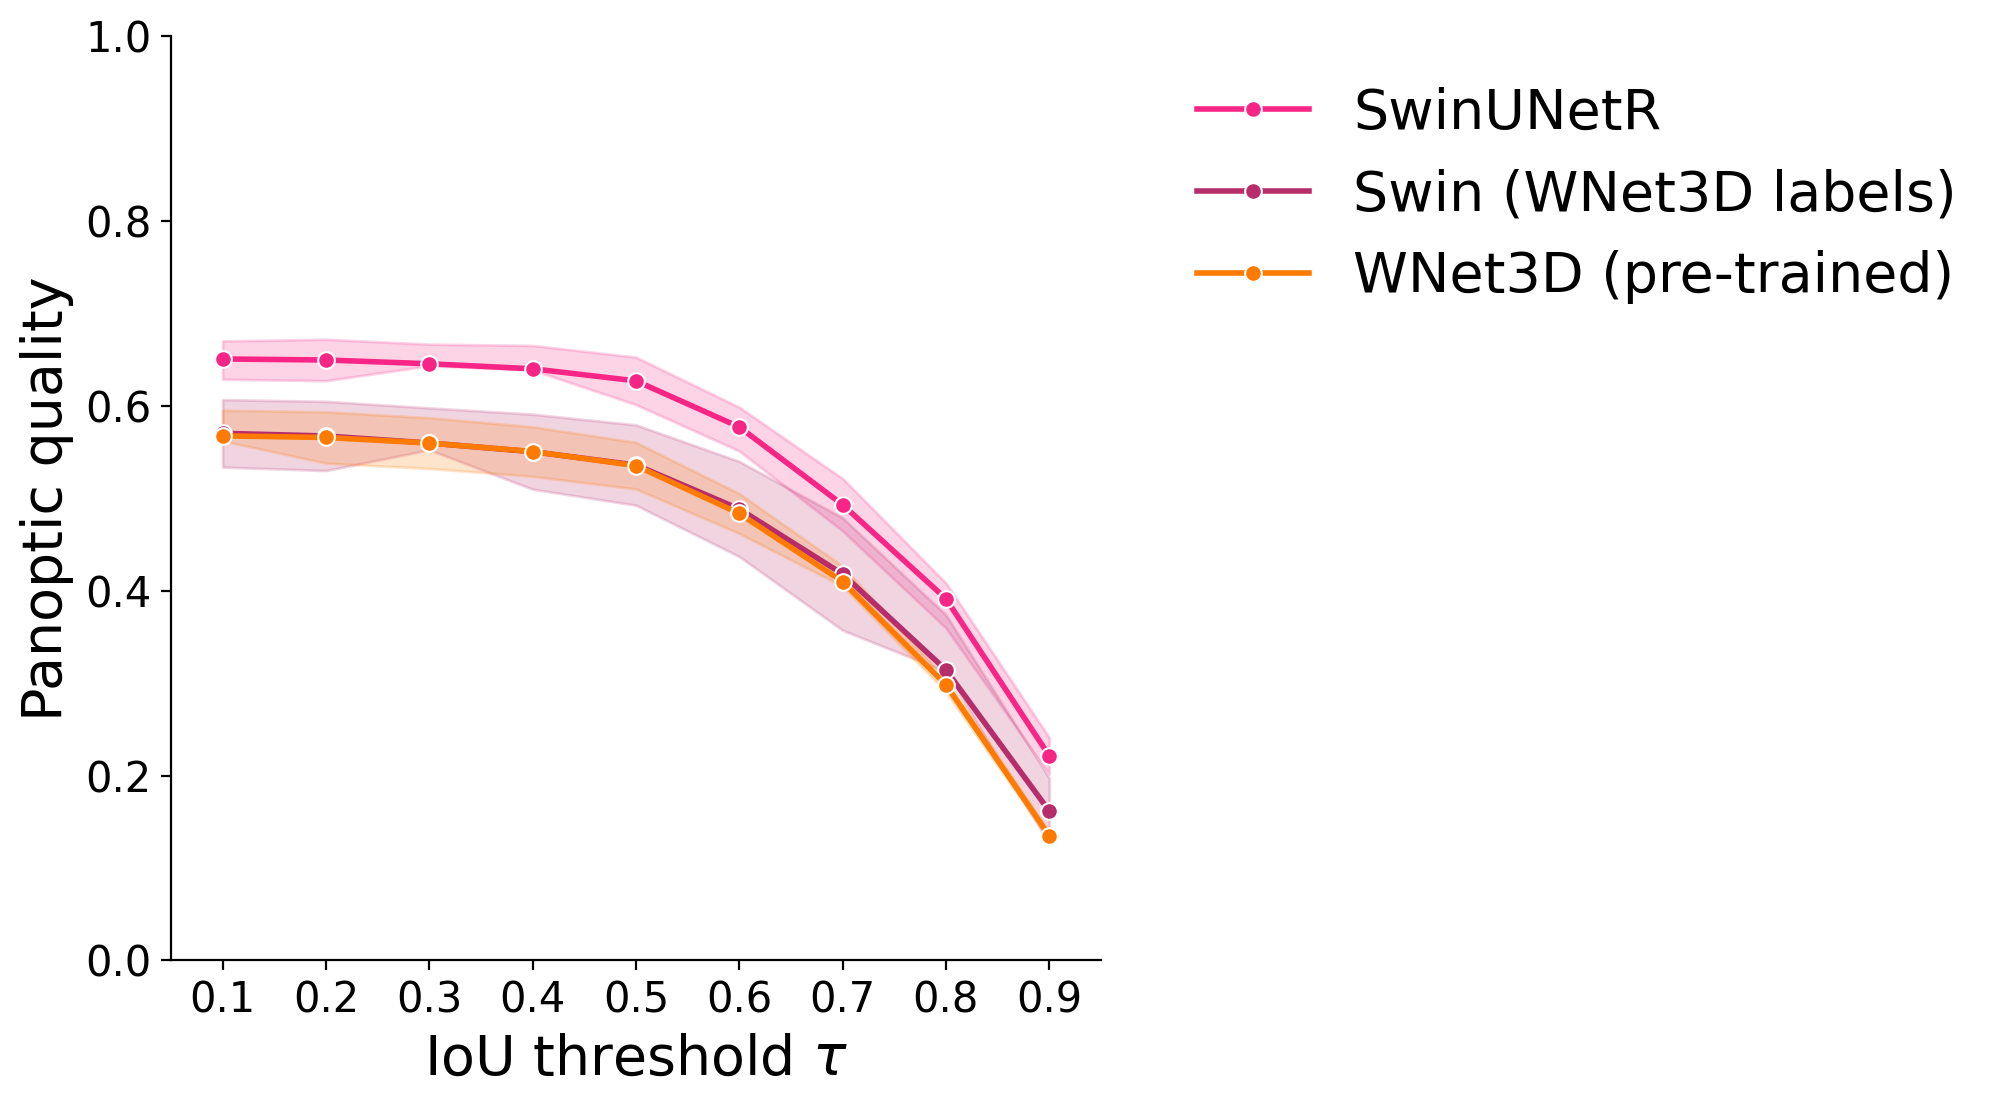

In [17]:
plot_stat_comparison_fold(df, stat="panoptic_quality", colormap=CUSTOM_CMAP)
if SAVE_PLOTS_AS_PNG:
    plt.savefig("panoptic_quality_comparison.png")
if SAVE_PLOTS_AS_SVG:
    plt.savefig( "panoptic_quality_comparison.svg", bbox_inches="tight")